In [1]:
from io import StringIO
from urllib import request
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import ssl
import pandas as pd
import numpy as np

## Data normalization


Dataset: [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg)

This dataset is a slightly modified version of the dataset provided in the StatLib library. In line with the use by Ross Quinlan (1993) in predicting the attribute "mpg", 8 of the original instances were removed because they had unknown values for the "mpg" attribute. The original dataset is available in the file "auto-mpg.data-original".

The data concerns city-cycle fuel consumption in miles per gallon, to be predicted in terms of 3 multivalued discrete and 5 continuous attributes.

In [2]:
ssl._create_default_https_context = ssl._create_unverified_context

names =["mpg","cylinders","displacement","horsepower",
        "weight","acceleration","model year","origin","car name"]

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
s = request.urlopen(url).read().decode('utf8')

dataFile = StringIO(s)
cReader = pd.read_csv(dataFile,delim_whitespace=True,names=names)

Download data from UCI Machine Learning Repository and show the first 5 line 

In [3]:
trainData = cReader[['mpg','displacement','acceleration']]
trainData.insert(0,'ones',1)
trainData.head()

,ones,mpg,displacement,acceleration
0,1,18.0,307.0,12.0
1,1,15.0,350.0,11.5
2,1,18.0,318.0,11.0
3,1,16.0,304.0,12.0
4,1,17.0,302.0,10.5


Add a column matrix `trainData.insert(0,'ones',1)` to the first column of the training data, the purpose is to simplify the calculation when performing linear regression, because our target equation is $$ h(x)= θ_0+ θ_1*𝓧1+ θ_2*𝓧_2 $$  A constant term of can be regarded as the product of $θ_0 and 1$, and the other terms are the product of  $θi and  𝓧i$
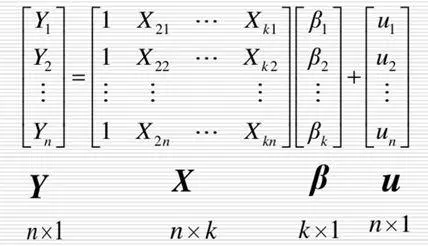

In [4]:
cols = trainData.shape[1]
X = trainData.iloc[:,0:cols-1]
Y = trainData.iloc[:,cols-1:cols]
X = np.mat(X.values)
Y = np.mat(Y.values)

for i in range(1,3):
    X[:,i] = (X[:,i] - min(X[:,i])) / (max(X[:,i]) - min(X[:,i]))
Y[:,0] = (Y[:,0] - min(Y[:,0])) / (max(Y[:,0]) - min(Y[:,0]))

Here, the following formulas are used for normalization, corresponding to the last three lines of the above code:
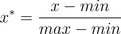

### Data visualization

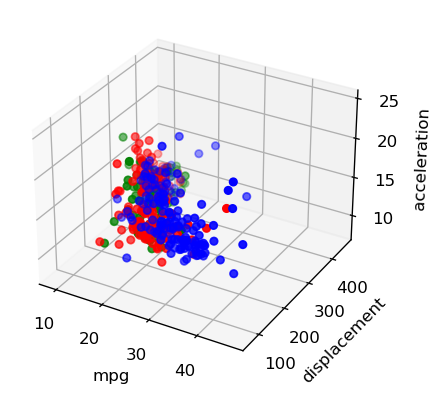

In [5]:
plt.figure(dpi = 120) 

ax = plt.subplot(111, projection='3d') 
ax.scatter(cReader["mpg"][:100],cReader["displacement"][:100],cReader["acceleration"][:100],c='g')
ax.scatter(cReader["mpg"][100:250],cReader["displacement"][100:250],cReader["acceleration"][100:250],c='r')
ax.scatter(cReader["mpg"][250:],cReader["displacement"][250:],cReader["acceleration"][250:],c='b')

ax.set_zlabel('acceleration') 
ax.set_ylabel('displacement')
ax.set_xlabel('mpg')
plt.show()

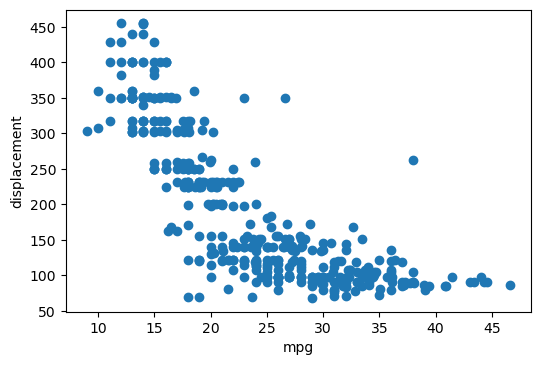

In [6]:
plt.figure(dpi = 100) 
plt.scatter(cReader["mpg"],cReader["displacement"])
plt.xlabel('mpg')
plt.ylabel('displacement')
plt.show()

### Start regression analysis

1. The regression coefficients are first calculated by the least squares method, and the code representation of the cost function of gradient descent is given
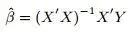

In [7]:
theta_n = (X.T*X).I*X.T*Y
print(theta_n)

[[ 0.58007057]
 [-0.0378746 ]
 [-0.35473364]]


The result: `[[ 0.58007057] [-0.0378746 ] [-0.35473364]]`，from left to right: $θ_0，θ_1，θ_2$

2. Define the cost function:
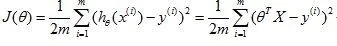
> h(x) is the predicted value, and y is the actual value. The difference between them is used to reflect the reliability of different fitting curves. The smaller the value is, the closer the curve fitted by the corresponding coefficient θ is to the actual value. What we do is to use the gradient descent algorithm to take a series of θ values to approximate this optimal solution, and finally get the regression curve.

In [8]:
def costFunc(X,Y,theta):
    inner = np.power((X*theta.T)-Y,2)
    return np.sum(inner)/(2*len(X))

3. Gradient Descent Algorithm
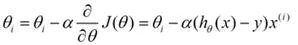
> alpha is 𝒂 in the formula, which we usually call the step size, which determines the speed at which θ approaches the optimal solution. If it is too large, the function will not converge and the optimal solution will not be obtained. If it is too small, the approximation speed will be too slow.
iters is the number of iterations, and the θ obtained is convincing when it is large enough
theta is a set of θ values given during the initialization iteration, and finally the θ with the highest fit is obtained and returned in the function

In [9]:
def gradientDescent(X,Y,theta,alpha,iters):
    temp = np.mat(np.zeros(theta.shape))
    cost = np.zeros(iters)
    thetaNums = int(theta.shape[1])
    for i in range(iters):
        error = (X*theta.T-Y)
        for j in range(thetaNums):
            derivativeInner = np.multiply(error,X[:,j])
            temp[0,j] = theta[0,j] - (alpha*np.sum(derivativeInner)/len(X))

        theta = temp
        cost[i] = costFunc(X,Y,theta)

    return theta,cost

4. Begin regression

set parameter

In [10]:
theta = np.mat([0,0,0])
iters = 100000
alpha = 0.001

In [11]:
finalTheta,cost = gradientDescent(X,Y,theta,alpha,iters)
print('Final θ:',finalTheta)
print('Cost function value:',cost)

Final θ: [[ 0.48684398  0.11075083 -0.24651519]]
Cost function value: [0.1146522  0.11439975 0.11414793 ... 0.00963298 0.00963298 0.00963298]


5. Regression results and visualization

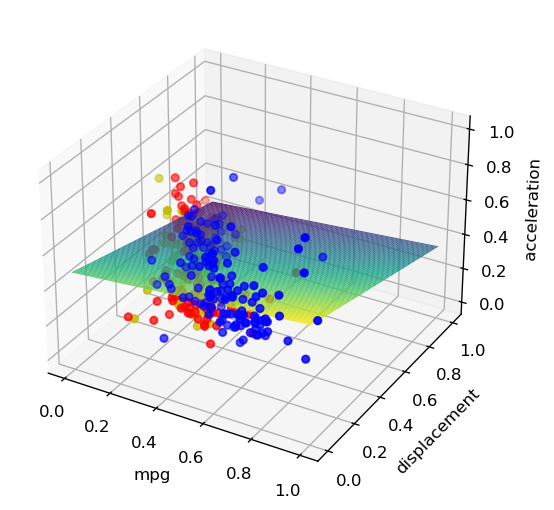

In [12]:
x1 = np.linspace(X[:,1].min(),X[:,1].max(),100)
x2 = np.linspace(X[:,2].min(),X[:,2].max(),100)

x1,x2 = np.meshgrid(x1,x2)
f = finalTheta[0,0] + finalTheta[0,1]*x1 + finalTheta[0,2]*x2

fig = plt.figure(dpi = 120) 
Ax = Axes3D(fig,auto_add_to_figure=False)
fig.add_axes(Ax)
Ax.plot_surface(x1, x2, f, rstride=1, cstride=1, cmap=cm.viridis,label='prediction')

Ax.scatter(X[:100,1],X[:100,2],Y[:100,0],c='y')
Ax.scatter(X[100:250,1],X[100:250,2],Y[100:250,0],c='r')
Ax.scatter(X[250:,1],X[250:,2],Y[250:,0],c='b')

Ax.set_zlabel('acceleration') 
Ax.set_ylabel('displacement')
Ax.set_xlabel('mpg')

plt.show()

The denser parts are basically distributed above and below the plane.

4. Gradient descent process visualization


As the number of iterations increases, the cost function becomes smaller and smaller, the trend becomes more stable, and the optimal solution is approached at the same time.

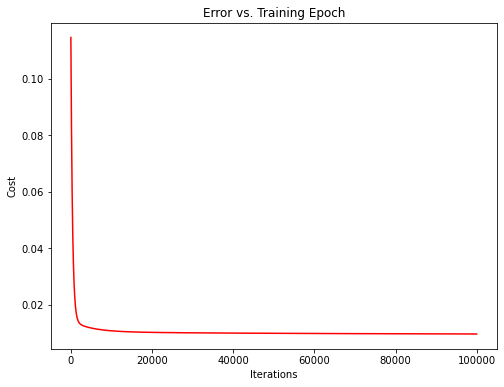

In [13]:
fig, bx = plt.subplots(figsize=(8,6))
bx.plot(np.arange(iters), cost, 'r') 
bx.set_xlabel('Iterations') 
bx.set_ylabel('Cost') 
bx.set_title('Error vs. Training Epoch') 
plt.show()